In [1]:
from LensCalcPy.survey import *
from LensCalcPy.ffp import *
from LensCalcPy.utils import *
from LensCalcPy.parameters import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
from astropy.coordinates import SkyCoord
from scipy.interpolate import interp1d, interp2d
from scipy.integrate import quad, nquad
from tqdm import tqdm
from pathos.multiprocessing import ProcessingPool as Pool
import functools
from scipy.stats import poisson
import seaborn as sns
sns.set_palette("colorblind")

%load_ext autoreload
%autoreload 2

In [2]:
plt.style.use("style.mplstyle")
sns.set_palette("colorblind")

In [3]:
def plot_line_of_sight(s, ax):
    d_arr = np.linspace(1, s.source_dist, num=1000)

    rho_ffp_mw = [s.mw_model.density_stars(d, l = s.l, b = s.b) for d in d_arr]
    rho_ffp_m31 = [s.m31_model.density_stars(d) for d in d_arr]
    rho_dm_mw = [s.mw_model.density_dm(d, l = s.l, b = s.b) for d in d_arr]
    rho_dm_m31 = [s.m31_model.density_dm(d) for d in d_arr]

    ax.plot(d_arr, rho_ffp_mw, label="MW UBOs")
    ax.plot(d_arr, rho_dm_mw, label="MW DM", linestyle="--", color="C0")

    if not s.use_mw_source:
        ax.plot(d_arr, rho_ffp_m31, label="M31 UBOs")
        ax.plot(d_arr, rho_dm_m31, label="M31 DM", linestyle="--", color="C1")

    ax.set_xlabel(r"$d$ [kpc]", fontsize=16)
    ax.set_ylabel(r"$\rho$ [M$_\odot$/$\mathrm{kpc}^3$]", fontsize=16)
    if s.use_mw_source:
        ax.set_title(r'MW Survey - LoS: l = ${:.2f}^\circ$, b = ${:.2f}^\circ$'.format(s.l, s.b), fontsize=16)
    else:
        ax.set_title(r'M31 Survey - LoS: l = ${:.2f}^\circ$, b = ${:.2f}^\circ$'.format(s.l, s.b), fontsize=16)

    ax.legend(fontsize=14)

    ax.set_yscale("log")
    ax.set_xlim(1e0, s.source_dist)
    ax.set_ylim(1e2, 1e10)


In [4]:
def tess_efficiency(t):
    '''
    Takes in crossing time in hours and returns the efficiency of TESS
    #Need to replace this eventually. Assume perfect efficiency for now
    '''
    return 1.0


In [5]:
tess_1_df = pd.read_csv('tess_dat/s0001.csv')
tess_27_df = pd.read_csv('tess_dat/s0027.csv')


In [6]:
n_sources_tess_1 = len(tess_1_df)
n_sources_tess_27 = len(tess_27_df)


In [7]:
def get_galactic_coords(ra, dec):
    coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='icrs')
    galactic_coord = coord.galactic
    return galactic_coord.l.degree, galactic_coord.b.degree

In [8]:
get_galactic_coords(221.86, 41.76)

(72.16071690615225, 62.16907399101691)

In [9]:
#Camera central coordinates for sector 1
fov_dict = {"c_1_1": (324.57, -33.17), "c_1_2": (338.58, -55.08), "c_1_3": (19.49, -71.98), "c_1_4": (90.00, -66.56),
            "c_27_1": (301.60, -38.68), "c_27_2": (312.45, -61.74), "c_27_3": (8.60, -79.81), "c_27_4": (90.01, -66.56)}


In [10]:
fov_galac_dict = {}
for cam in fov_dict.keys():
    l, b = get_galactic_coords(fov_dict[cam][0],fov_dict[cam][1])
    fov_galac_dict[cam] = [l,b]

In [11]:
fov_galac_dict

{'c_1_1': [12.48454296055821, -48.17248553522726],
 'c_1_2': [335.0269214572734, -52.641078854533035],
 'c_1_3': [300.03646421703394, -44.99884771091424],
 'c_1_4': [276.38316044756886, -29.811440130322914],
 'c_27_1': [2.065463142346148, -30.543561066152407],
 'c_27_2': [334.2267863075157, -37.56880169013005],
 'c_27_3': [303.87823755587146, -37.28692726368817],
 'c_27_4': [276.38315898971274, -29.807462245454307]}

In [12]:
#! survey_area should really be diameter, but not used in any calculations
#! Need to create finite size calculation for TESS distances and sensitivity (1% magnification) and general u_t 

survey_param_dict = {
    "tess_1_1": {"l": fov_galac_dict['c_1_1'][0], "b": fov_galac_dict['c_1_1'][1], "source_dist": 8.5, "obs_time": 27.4*24, "cadence": 30/60, "survey_area": 1.5, "n_sources": n_sources_tess_1/4, "efficiency": tess_efficiency, "use_mw_source":True, "A_t": 1.01},
    "tess_1_2": {"l": fov_galac_dict['c_1_2'][0], "b": fov_galac_dict['c_1_2'][1], "source_dist": 8.5, "obs_time": 27.4*24, "cadence": 30/60, "survey_area": 1.5, "n_sources": n_sources_tess_1/4, "efficiency": tess_efficiency, "use_mw_source":True, "A_t": 1.01},
    "tess_1_3": {"l":  fov_galac_dict['c_1_3'][0], "b": fov_galac_dict['c_1_3'][1], "source_dist": 8.5, "obs_time": 27.4*24, "cadence": 30/60, "survey_area": 1.5, "n_sources": n_sources_tess_1/4, "efficiency": tess_efficiency, "use_mw_source":True, "A_t": 1.01},
    "tess_1_4": {"l":  fov_galac_dict['c_1_4'][0], "b": fov_galac_dict['c_1_4'][1], "source_dist": 8.5, "obs_time": 27.4*24, "cadence": 30/60, "survey_area": 1.5, "n_sources": n_sources_tess_1/4, "efficiency": tess_efficiency, "use_mw_source":True, "A_t": 1.01},
    "tess_27_1": {"l":  fov_galac_dict['c_27_1'][0], "b": fov_galac_dict['c_27_1'][1], "source_dist": 8.5, "obs_time": 27.4*24, "cadence": 10/60, "survey_area": 1.5, "n_sources": n_sources_tess_27/4, "efficiency": tess_efficiency, "use_mw_source":True, "A_t": 1.01},
    "tess_27_2": {"l":  fov_galac_dict['c_27_2'][0], "b": fov_galac_dict['c_27_2'][1], "source_dist": 8.5, "obs_time": 27.4*24, "cadence": 10/60, "survey_area": 1.5, "n_sources": n_sources_tess_27/4, "efficiency": tess_efficiency, "use_mw_source":True, "A_t": 1.01},
    "tess_27_3": {"l":  fov_galac_dict['c_27_3'][0], "b": fov_galac_dict['c_27_3'][1], "source_dist": 8.5, "obs_time": 27.4*24, "cadence": 10/60, "survey_area": 1.5, "n_sources": n_sources_tess_27/4, "efficiency": tess_efficiency, "use_mw_source":True, "A_t": 1.01},
    # "tess_27_4": {"l":  fov_galac_dict['c_27_4'][0], "b": fov_galac_dict['c_27_4'][1], "source_dist": 8.5, "obs_time": 27.4*24, "cadence": 10/60, "survey_area": 1.5, "n_sources": n_sources_tess_27/4, "efficiency": tess_efficiency, "use_mw_source":True, "A_t": 1.01},
    "tess_max_cad_test": {"l":  fov_galac_dict['c_27_4'][0], "b": fov_galac_dict['c_27_4'][1], "source_dist": 8.5, "obs_time": 27.4*24, "cadence": 3.3/60, "survey_area": 1.5, "n_sources": n_sources_tess_27/4, "efficiency": tess_efficiency, "use_mw_source":True, "A_t": 1.01},
    
}

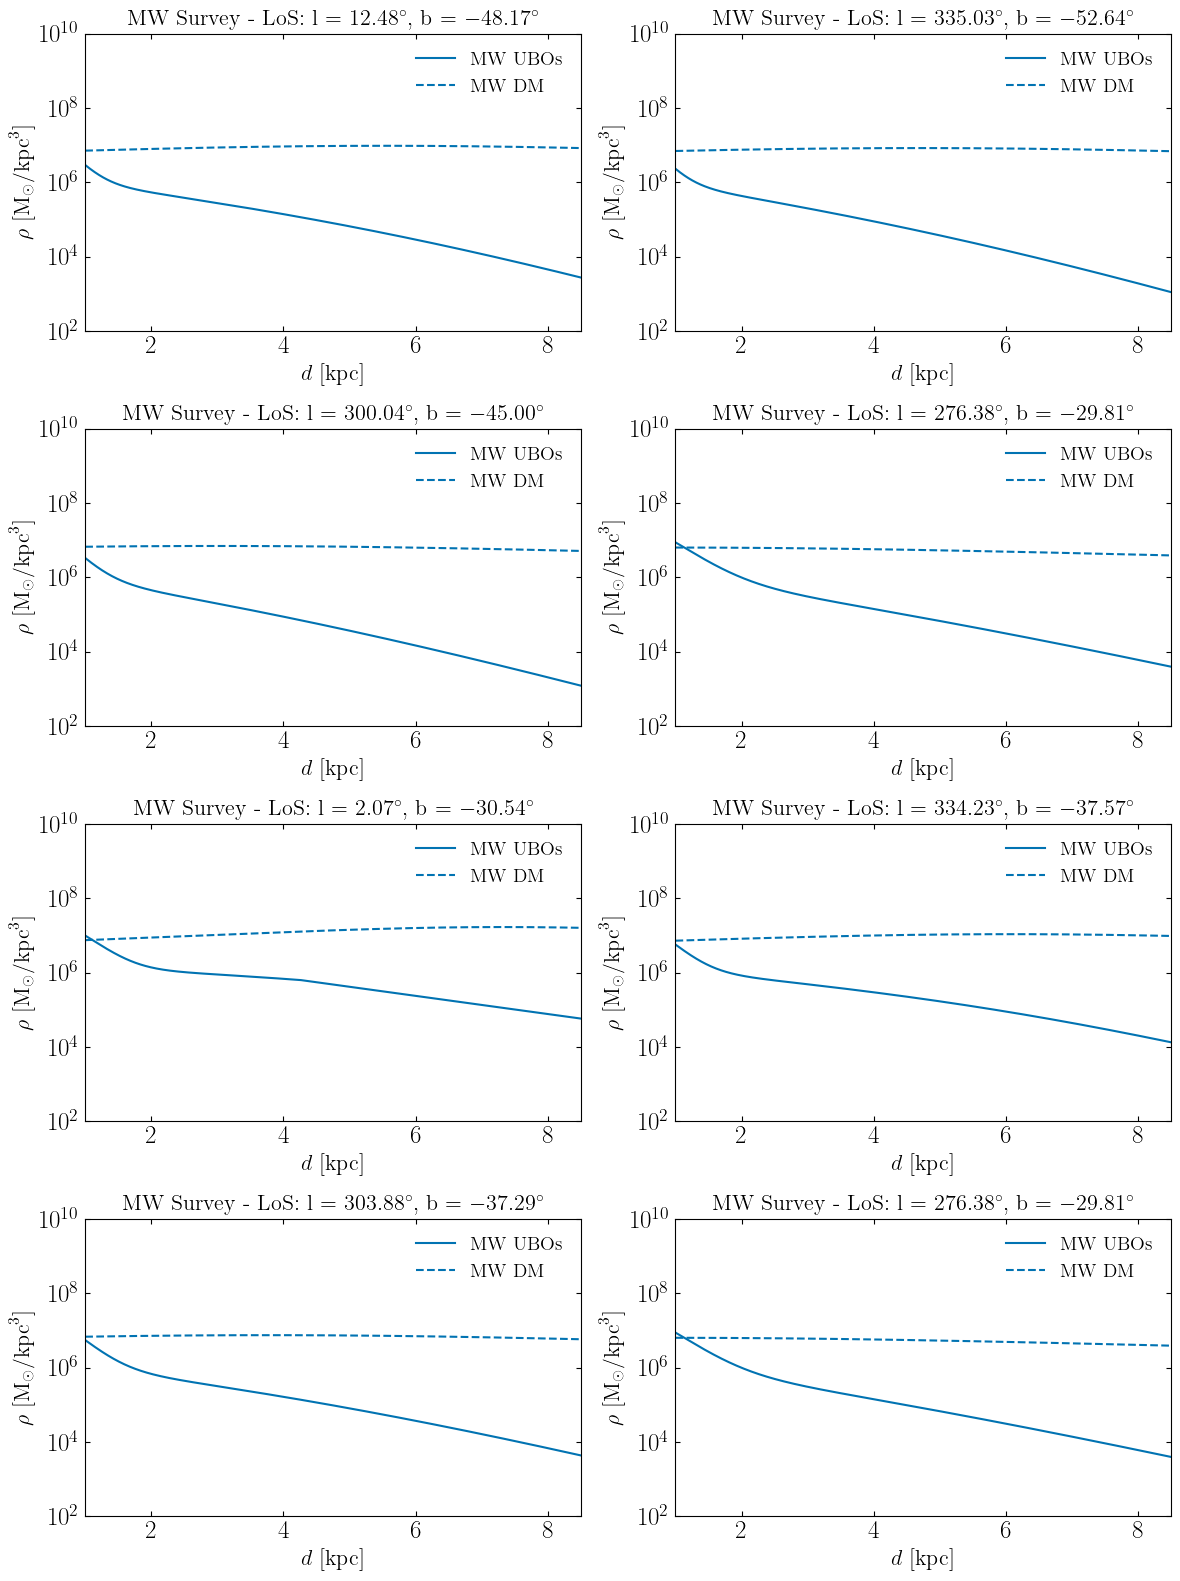

In [13]:
n_params = len(survey_param_dict)
n_cols = 2
n_rows = (n_params + n_cols - 1) // n_cols

# Create a figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4))
axes = axes.flatten()  

# Loop through the parameter sets and create subplots
for i, param_set in enumerate(survey_param_dict.values()):
    s = Survey(**param_set)
    ax = axes[i]
    plot_line_of_sight(s, ax)

plt.tight_layout()

In [14]:
#J-factor like metric to compare density of UBOs
def ubo_factor(s):
    #integrated density of UBOs along line of sight (not include finite size effects)
    d_arr = np.linspace(0, s.source_dist, 1000) #kpc
    rho_ffp_mw = [s.mw_model.density_stars(d, l = s.l, b = s.b) for d in d_arr]
    
    rho_ffp_interp = interp1d(d_arr, rho_ffp_mw)

    return quad(rho_ffp_interp, 0, s.source_dist)[0] 

In [15]:
get_galactic_coords(249.34, -40.26)


(342.5953166917298, 4.609679258782221)

In [16]:
d_arr = np.linspace(0, 8.5, 1000) #kpc
rho_ffp_mw = [s.mw_model.density_stars(d, l = 342.5953166917298, b = 4.609679258782221) for d in d_arr]

rho_ffp_interp = interp1d(d_arr, rho_ffp_mw)

quad(rho_ffp_interp, 0, s.source_dist)[0] 

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_9682/3764316714.py:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad(rho_ffp_interp, 0, s.source_dist)[0]


356283464.89542794

Expected number of events

In [17]:
# t_es = np.logspace(-2, 1, 20) #hours

In [18]:
# def get_n_events(s, p=1, finite=True):
#     #get expected number of events for pdf-powerlaw. Note that you need to normalize this
#     t_es = np.logspace(np.log10(s.cadence*2), np.log10(s.obs_time/2), 30) 
#     s.add_ffp(p)
#     diff_rates = s.get_crossing_times_rates_ffp(t_es, finite=finite)
#     # efficiencies = np.array([ogle_efficiency(t_e) for t_e in t_es])
#     efficiencies = np.array([s.efficiency(t_e) for t_e in t_es])
#     diff_rates_w_efficiency = diff_rates*efficiencies
#     # rate_interp = interp1d(t_es, diff_rates)
#     rate_interp = interp1d(t_es, diff_rates_w_efficiency)
#     if s.cadence*2 > s.obs_time/2:
#         raise ValueError("Cadence is too short relative to total observation time")
#     #? using 2x the cadence and 1/2 the observation time for now. Comparable to Fig 18 of https://arxiv.org/pdf/1701.02151.pdf sensitivity
#     dnds = quad(rate_interp, s.cadence*2, s.obs_time/2)[0]
#     # return s.n_sources*s.efficiency*dnds*s.obs_time
#     return s.n_sources*dnds*s.obs_time


In [19]:
ms = np.logspace(-12, -3, 20)
def get_n_events(s, p=1, finite=True):
    s.add_ffp(p)
    diff_rates_mw = np.array([s.ffp.differential_rate_mw_mass(m, efficiency=s.efficiency, tcad = s.cadence*2, tobs=s.obs_time) for m in ms])
    diff_rates_interp_log = interp1d(np.log10(ms), np.log10(diff_rates_mw))
    def diff_rates_interp(m):
        return 10**diff_rates_interp_log(np.log10(m))
    dnds = quad(diff_rates_interp, min(ms), max(ms), epsabs=0, epsrel=1e-1, points=[min(ms), np.median(ms), max(ms)])[0]
    return s.n_sources*dnds*s.obs_time


In [20]:
s1 = Survey(**survey_param_dict["tess_1_1"])
s2 = Survey(**survey_param_dict["tess_27_3"])
s1.add_ffp(1)
s2.add_ffp(1)
diff_rates_mw1 = np.array([s1.ffp.differential_rate_mw_mass(m, efficiency=s1.efficiency, tcad = s1.cadence*2, tobs=s1.obs_time) for m in ms])
diff_rates_mw2 = np.array([s2.ffp.differential_rate_mw_mass(m, efficiency=s2.efficiency, tcad = s2.cadence*2, tobs=s2.obs_time) for m in ms])


In [21]:
diff_rates_interp_log = interp1d(np.log10(ms), np.log10(diff_rates_mw1))
def diff_rates_interp(m):
    return 10**diff_rates_interp_log(np.log10(m))
dnds1 = quad(diff_rates_interp, min(ms), max(ms), epsabs=0, epsrel=1e-1, points=[min(ms), np.median(ms), max(ms)])[0]

In [22]:
diff_rates_interp_log = interp1d(np.log10(ms), np.log10(diff_rates_mw2))
def diff_rates_interp(m):
    return 10**diff_rates_interp_log(np.log10(m))
dnds2 = quad(diff_rates_interp, min(ms), max(ms), epsabs=0, epsrel=1e-1, points=[min(ms), np.median(ms), max(ms)])[0]

In [23]:
s1.ffp.differential_rate_integrand(0.1, 3, 1, 1e-9, s1.ffp.mw_model)

1.1022634201901715e-18

In [24]:
s2.ffp.differential_rate_integrand(0.1, 3, 1, 1e-9, s1.ffp.mw_model)


1.2669100417706397e-18

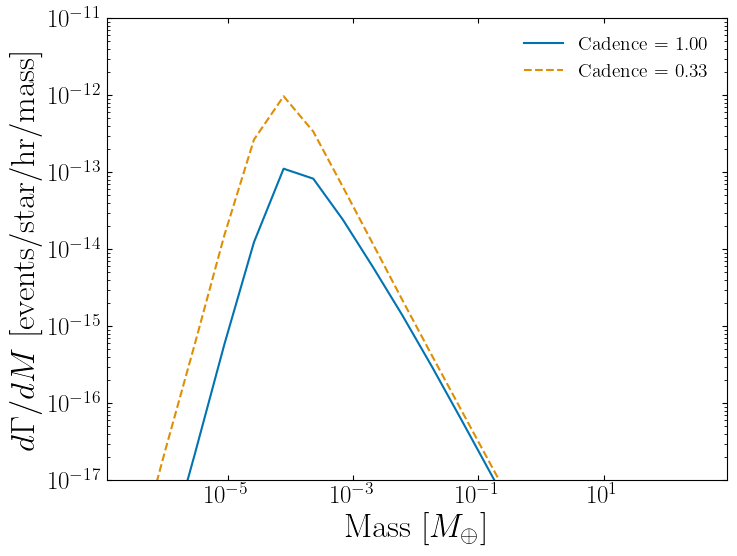

In [25]:
plt.plot(ms/3e-6, diff_rates_mw1, label=f"Cadence = {s1.cadence*2:.2f}")
plt.plot(ms/3e-6, diff_rates_mw2, label=f"Cadence = {s2.cadence*2:.2f}", ls='--')
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"Mass [$M_\oplus$]")
plt.ylabel(r"$d\Gamma/dM$ [events/star/hr/mass]")

plt.ylim(1e-17, 1e-11)

plt.legend()
plt.show()

In [ ]:
## 30 knm/s for vc, put everything at 1.5 kpc, use central telescope fov, run 

In [26]:
def get_num_events_fiducial(s, finite=True):

    #power law, normalization, and normalization mass for fiducial mass function
    p = 1
    Z_fiducial = 10
    M_norm = 3e-6 #earth mass in solar mass units

    #number of events for a power law normalized to 1 UBO per star total
    #! Check that this is using the correct l and b
    n_events = get_n_events(s, p=p, finite=finite)

    #rescale normalization of pdf to M_norm = earth mass if not already
    z_earth = s.ffp.Z*(M_norm/s.ffp.M_norm)**(-p) 

    #number of objects per star for fiducial mass function at 1 earth mass

    num_events_fiducial = n_events * Z_fiducial/z_earth

    return num_events_fiducial

In [27]:
def compute_expected_num_events(survey_name_and_params):
    survey_name, param_set = survey_name_and_params
    s = Survey(**param_set)
    expected_num_events_finite = get_num_events_fiducial(s, finite=True)
    expected_num_events_point = get_num_events_fiducial(s, finite=False)
    return survey_name, expected_num_events_finite, expected_num_events_point

survey_name_and_params_list = [(survey_name, params) for survey_name, params in survey_param_dict.items()]

with Pool() as pool:
    results = list(tqdm(pool.imap(compute_expected_num_events, survey_name_and_params_list), total=len(survey_name_and_params_list)))


100%|██████████| 8/8 [04:16<00:00, 32.10s/it] 


In [28]:
num_events_dict = {}
num_events_point_dict = {}

for survey_name, expected_num_events_finite, expected_num_point_events in results:
    num_events_dict[survey_name] = expected_num_events_finite
    num_events_point_dict[survey_name] = expected_num_point_events

In [29]:
ubo_factor_dict = {}
for i, survey_name in enumerate(survey_param_dict.keys()):
    param_set = survey_param_dict[survey_name]
    s = Survey(**param_set)
    ubo_factor_dict[survey_name] = ubo_factor(s)

/var/folders/qd/09mj47cx551c65glw6y47d6r0000gn/T/ipykernel_9682/3079570761.py:9: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(rho_ffp_interp, 0, s.source_dist)[0]


In [30]:
# Create a list of dictionaries for the table
table_data = []
for survey_name, param_set in survey_param_dict.items():
    row = {
        "Survey": survey_name,
        "l": param_set["l"],
        "b": param_set["b"],
        "n_sources": param_set["n_sources"],
        "ubo_factor": ubo_factor_dict[survey_name],
        "obs_time": param_set["obs_time"],
        # "num_expected_events_tot": num_events_dict[survey_name],
        "N/h finite": float(num_events_dict[survey_name]) / float(param_set["obs_time"]),
        # "num_expected_events_point_tot": num_events_point_dict[survey_name],
        "N/h point": float(num_events_point_dict[survey_name]) / float(param_set["obs_time"]),
        "finite_factor": (float(num_events_dict[survey_name]) / float(param_set["obs_time"]))/(float(num_events_point_dict[survey_name]) / float(param_set["obs_time"]))

    }
    table_data.append(row)

df = pd.DataFrame(table_data)
df = df[["Survey", "l", "b", "n_sources", "ubo_factor", "obs_time", "N/h finite", "N/h point", "finite_factor"]]


In [31]:
# Define a function to format large numbers in scientific notation
def scientific_format(x):
    return '{:.4e}'.format(x)

# Apply styling to the DataFrame
styled_df = (
    df.style
    .format({
        'l': '{:.1f}',
        'b': '{:.1f}',
        'n_sources': '{:.1e}',
        'ubo_factor': '{:.1e}',
        'obs_time': '{:.1f}',
        # 'num_expected_events_tot': '{:.1e}',
        'N/h finite': '{:.1e}',
        # 'num_expected_events_point_tot': '{:.1e}',
        'N/h point': '{:.1e}',
        'finite_factor': '{:.1e}',
        
    })
    .set_table_styles([
        {'selector': 'th', 'props': [('font-size', '14pt'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('font-size', '12pt'), ('text-align', 'center')]}
    ])
    .set_caption('Survey Parameters and Expected Events')
)

styled_df

#! WHy doesn't ubo_factor seem to matter much?

,Survey,l,b,n_sources,ubo_factor,obs_time,N/h finite,N/h point,finite_factor
0,tess_1_1,12.5,-48.2,1.2e+05,2.2e+07,657.6,3.8e-07,3.8e-07,1.0e+00
1,tess_1_2,335.0,-52.6,1.2e+05,2.0e+07,657.6,3.2e-07,3.2e-07,1.0e+00
2,tess_1_3,300.0,-45.0,1.2e+05,2.2e+07,657.6,3.8e-07,3.8e-07,1.0e+00
3,tess_1_4,276.4,-29.8,1.2e+05,3.0e+07,657.6,6.4e-07,6.4e-07,1.0e+00
4,tess_27_1,2.1,-30.5,1.6e+05,3.5e+07,657.6,2.3e-06,2.3e-06,1.0e+00
5,tess_27_2,334.2,-37.6,1.6e+05,2.8e+07,657.6,1.7e-06,1.7e-06,1.0e+00
6,tess_27_3,303.9,-37.3,1.6e+05,2.6e+07,657.6,1.6e-06,1.6e-06,1.0e+00
7,tess_max_cad_test,276.4,-29.8,1.6e+05,3.0e+07,657.6,2.7e-06,2.7e-06,1.0e+00


In [75]:
#rough estimate of total # events for all fOv of tess
657.6 * 4 * (25 * 4.0e-07 + 25 * 1.8e-06 + 10*2.7e-06)

0.21569279999999996

In [44]:
vc = 30
dlstar = 1
tmin = 0.07
c = 3e8
GG = 6.67e-11

vc**2 * tmin**2/(16 * GG * dlstar) * 2.626 * 10**(-6)* c**2 / (1.989 * 10**30)/(3e-6)

0.0001636718405503131

In [63]:
Rs = 2.25461e-11
# ds = 8.5
ds = 770
c = 3e5
Rs**2 / (4 * G * ds) * (dlstar/ds) * c**(2) / 3e-6

1.4953891158064225e-06

In [64]:
tess_surveys = df[df['Survey'].str.startswith('tess')]

total_finite_events_tess = (tess_surveys['N/h finite'] * tess_surveys['obs_time']).sum()
total_point_events_tess = (tess_surveys['N/h point'] * tess_surveys['obs_time']).sum()

print("Total number of events detected by TESS, inluding finite-source effects:", total_finite_events_tess)
print("Total number of point events detected by TESS, point source:", total_point_events_tess)

Total number of events detected by TESS, inluding finite-source effects: 0.006521184517319793
Total number of point events detected by TESS, point source: 0.006521184517319793
